## 2.1.KALMAN FILTER (2D MOTION MODEL)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# =============================================================================
# PHẦN 1: MÃ NGUỒN GỐC (CHO BÀI 1a, 1b, 1d)
# Lớp Kalman Filter 2D (4-chiều state: x, y, vx, vy)
# =============================================================================

class KalmanCV2D:
    def __init__(self, dt=1.0, process_var=1e-2, meas_var=4.0):
        self.dt = float(dt)
        dt = self.dt

        # F - Ma trận chuyển tiếp (State Transition)
        self.F = np.array([[1,0,dt,0],
                           [0,1,0,dt],
                           [0,0,1,0],
                           [0,0,0,1]], dtype=float)

        # H - Ma trận đo lường (Measurement)
        self.H = np.array([[1,0,0,0],
                           [0,1,0,0]], dtype=float)

        # Q - Hiệp phương sai nhiễu quá trình (Process Noise)
        q = float(process_var)
        self.Q = q * np.array([[dt**4/4, 0, dt**3/2, 0],
                               [0, dt**4/4, 0, dt**3/2],
                               [dt**3/2, 0, dt**2, 0],
                               [0, dt**3/2, 0, dt**2]], dtype=float)

        # R - Hiệp phương sai nhiễu đo lường (Measurement Noise)
        r = float(meas_var)
        self.R = r * np.eye(2, dtype=float)

        # x - Vector trạng thái [x, y, vx, vy]
        self.x = np.zeros((4,1), dtype=float)

        # P - Hiệp phương sai của trạng thái (State Covariance)
        self.P = np.eye(4, dtype=float) * 20.0

    def init_state(self, x, y, vx=0.0, vy=0.0, P_scale=20.0):
        self.x[:] = np.array([[x],[y],[vx],[vy]], dtype=float)
        self.P = np.eye(4, dtype=float) * float(P_scale)

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x.copy()

    def update(self, z):
        z = np.asarray(z, dtype=float).reshape(2,1)

        # y - Sai số (Residual)
        y = z - self.H @ self.x

        # S - Hiệp phương sai của sai số
        S = self.H @ self.P @ self.H.T + self.R

        # K - Kalman Gain
        K = self.P @ self.H.T @ np.linalg.inv(S)

        # Cập nhật trạng thái và hiệp phương sai
        self.x = self.x + K @ y
        I = np.eye(self.P.shape[0])
        self.P = (I - K @ self.H) @ self.P

        return self.x.copy()

def simulate_trajectory(T=20, dt=1.0, accel_prob=0.2, accel_mag=0.5, meas_noise=2.0,
                        x0=10.0, y0=10.0, vx0=3.0, vy0=2.0):
    gt = []; meas = []
    x, y = float(x0), float(y0)
    vx, vy = float(vx0), float(vy0)
    for _ in range(T):
        if np.random.rand() < accel_prob:
            vx += np.random.uniform(-accel_mag, accel_mag)
            vy += np.random.uniform(-accel_mag, accel_mag)
        x += vx*dt
        y += vy*dt
        gt.append([x, y, vx, vy])
        meas.append([x + np.random.randn() * meas_noise,
                     y + np.random.randn() * meas_noise])
    return np.array(gt), np.array(meas)

def draw_frame(path, t, W, H, gt_xy, gt_v, z_xy, pred_xy, filt_xy, filt_v,
               rect_size=10):
    fig = plt.figure(figsize=(6,4))
    ax = plt.gca()
    ax.set_xlim(0, W); ax.set_ylim(0, H); ax.set_aspect('equal')
    ax.grid(True, linestyle='--', linewidth=0.5)

    # GT square (vẽ hình vuông tâm tại GT)
    s = rect_size
    ax.add_patch(plt.Rectangle((gt_xy[0]-s/2, gt_xy[1]-s/2), s, s, fill=False,
                               linewidth=2, label='GT (square center)', color='k'))

    # Measurement (x)
    ax.scatter([z_xy[0]], [z_xy[1]], s=50, marker='x', color='r', label='Measurement (x)')
    # Nối GT và Measurement
    ax.plot([gt_xy[0], z_xy[0]], [gt_xy[1], z_xy[1]], 'r--', linewidth=0.5)

    # Prediction (^)
    ax.scatter([pred_xy[0]], [pred_xy[1]], s=40, marker='^', facecolors='none', edgecolors='b', label='Prediction (^)')

    # Filtered (o)
    ax.scatter([filt_xy[0]], [filt_xy[1]], s=40, marker='o', facecolors='none', edgecolors='g', label='Filtered (o)')

    # Velocity arrows
    # Vận tốc Ground Truth
    ax.quiver([gt_xy[0]],[gt_xy[1]],[gt_v[0]],[gt_v[1]], angles='xy',
              scale_units='xy', scale=1, width=0.005, color='k')
    # Vận tốc đã lọc
    ax.quiver([filt_xy[0]],[filt_xy[1]],[filt_v[0]],[filt_v[1]], angles='xy',
              scale_units='xy', scale=1, width=0.005, color='g')

    ax.legend(loc='upper left', frameon=True)
    ax.set_title(f'Kalman 2D CV — frame {t:02d}')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    fig.tight_layout()
    plt.savefig(path, dpi=120)
    plt.close(fig)

# =============================================================================
# PHẦN 2: MÃ NGUỒN MỞ RỘNG (CHO BÀI 1c)
# Lớp Kalman Filter 6D (state: x, y, vx, vy, w, h)
# =============================================================================

class KalmanBBox6D:
    def __init__(self, dt=1.0,
                 process_var_xy=1e-2,  # Nhiễu cho vị trí/vận tốc
                 process_var_wh=1e-3,  # Nhiễu cho kích thước (nhỏ hơn)
                 meas_var_xy=4.0,      # Nhiễu đo vị trí
                 meas_var_wh=2.0):     # Nhiễu đo kích thước
        self.dt = float(dt)
        dt = self.dt

        # State: [x, y, vx, vy, w, h] (6D)

        # F - Ma trận chuyển tiếp (6x6)
        self.F = np.eye(6, dtype=float)
        self.F[0, 2] = dt
        self.F[1, 3] = dt

        # H - Ma trận đo lường (4x6)
        # Measurement z: [x, y, w, h] (4D)
        self.H = np.zeros((4, 6), dtype=float)
        self.H[0, 0] = 1
        self.H[1, 1] = 1
        self.H[2, 4] = 1
        self.H[3, 5] = 1

        # Q - Hiệp phương sai nhiễu quá trình (6x6)
        self.Q = np.zeros((6, 6), dtype=float)
        q_xy = float(process_var_xy)
        Q_xy = q_xy * np.array([[dt**4/4, 0, dt**3/2, 0],
                                [0, dt**4/4, 0, dt**3/2],
                                [dt**3/2, 0, dt**2, 0],
                                [0, dt**3/2, 0, dt**2]])
        self.Q[0:4, 0:4] = Q_xy

        # Thêm nhiễu cho w, h (giả định random walk đơn giản)
        q_wh = float(process_var_wh)
        self.Q[4, 4] = q_wh * dt**2
        self.Q[5, 5] = q_wh * dt**2

        # R - Hiệp phương sai nhiễu đo lường (4x4)
        self.R = np.diag(np.array([meas_var_xy, meas_var_xy,
                                   meas_var_wh, meas_var_wh], dtype=float))

        self.x = np.zeros((6,1), dtype=float)
        self.P = np.eye(6, dtype=float) * 20.0

    def init_state(self, x, y, vx=0.0, vy=0.0, w=10.0, h=10.0, P_scale=20.0):
        self.x[:] = np.array([[x],[y],[vx],[vy],[w],[h]], dtype=float)
        self.P = np.eye(6, dtype=float) * float(P_scale)

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x.copy()

    def update(self, z):
        z = np.asarray(z, dtype=float).reshape(4,1)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(self.P.shape[0])
        self.P = (I - K @ self.H) @ self.P
        return self.x.copy()

def simulate_trajectory_bbox(T=20, dt=1.0, accel_prob=0.2, accel_mag=0.5,
                             scale_prob=0.3, scale_mag=0.5,
                             meas_noise_xy=2.0, meas_noise_wh=1.0,
                             x0=10.0, y0=10.0, vx0=3.0, vy0=2.0, w0=10.0, h0=12.0):
    gt = []; meas = []
    x, y = float(x0), float(y0)
    vx, vy = float(vx0), float(vy0)
    w, h = float(w0), float(h0)

    for _ in range(T):
        # Mô phỏng chuyển động
        if np.random.rand() < accel_prob:
            vx += np.random.uniform(-accel_mag, accel_mag)
            vy += np.random.uniform(-accel_mag, accel_mag)
        x += vx*dt
        y += vy*dt

        # Mô phỏng thay đổi kích thước
        if np.random.rand() < scale_prob:
            w += np.random.uniform(-scale_mag, scale_mag)
            h += np.random.uniform(-scale_mag, scale_mag)
        w = max(1.0, w) # Đảm bảo kích thước > 0
        h = max(1.0, h)

        # State: [x, y, vx, vy, w, h]
        gt.append([x, y, vx, vy, w, h])

        # Measurement: [x, y, w, h] + noise
        meas.append([x + np.random.randn() * meas_noise_xy,
                     y + np.random.randn() * meas_noise_xy,
                     w + np.random.randn() * meas_noise_wh,
                     h + np.random.randn() * meas_noise_wh])
    return np.array(gt), np.array(meas)

def draw_frame_bbox(path, t, W, H, gt_state, z_meas, pred_state, filt_state):

    def get_rect_params(state_vec):
        # state_vec: [x, y, ..., w, h, ...]
        x, y = state_vec[0], state_vec[1]
        if len(state_vec) == 4: # Measurement
            w, h = state_vec[2], state_vec[3]
        else: # State
            w, h = state_vec[4], state_vec[5]
        return (x - w/2, y - h/2), w, h

    fig = plt.figure(figsize=(6,4))
    ax = plt.gca()
    ax.set_xlim(0, W); ax.set_ylim(0, H); ax.set_aspect('equal')
    ax.grid(True, linestyle='--', linewidth=0.5)

    # GT Box (Màu đen, nét liền)
    xy, w, h = get_rect_params(gt_state)
    ax.add_patch(plt.Rectangle(xy, w, h, fill=False, linewidth=2, color='k', label='GT Box'))

    # Measurement Box (Màu đỏ, nét chấm)
    xy, w, h = get_rect_params(z_meas)
    ax.add_patch(plt.Rectangle(xy, w, h, fill=False, linewidth=1, linestyle='--', color='r', label='Measurement Box'))

    # Prediction Box (Màu xanh dương, nét đứt)
    xy, w, h = get_rect_params(pred_state)
    ax.add_patch(plt.Rectangle(xy, w, h, fill=False, linewidth=1, linestyle='-.', color='b', label='Prediction Box'))

    # Filtered Box (Màu xanh lá, nét liền)
    xy, w, h = get_rect_params(filt_state)
    ax.add_patch(plt.Rectangle(xy, w, h, fill=False, linewidth=2, color='g', label='Filtered Box'))

    ax.legend(loc='upper left', frameon=True)
    ax.set_title(f'Kalman 6D BBox — frame {t:02d}')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    fig.tight_layout()
    plt.savefig(path, dpi=120)
    plt.close(fig)

# =============================================================================
# PHẦN 3: HÀM MAIN ĐỂ THỰC THI
# =============================================================================

def main_2d_tracking():
    """Chạy mô phỏng 2D cho bài 1a, 1b"""
    print("Bắt đầu mô phỏng 2D (Bài 1a, 1b)...")

    # --- THAM SỐ ĐỂ THAY ĐỔI ---
    # (a) Tăng meas_var (ví dụ: 10.0, 50.0)
    # (b) Thay đổi process_var (ví dụ: 1e-5 (quá trơn) hoặc 1.0 (quá nhiễu))
    PARAM_PROCESS_VAR = 1e-2
    PARAM_MEAS_VAR = 4.0
    PARAM_MEAS_NOISE_SIM = 2.0 # Độ nhiễu thực tế khi sinh dữ liệu
    # -------------------------

    T = 50
    dt = 1.0
    W, H = 100, 80 # Kích thước màn hình

    FRAMES_DIR = "kalman_frames_2d"
    if os.path.exists(FRAMES_DIR): shutil.rmtree(FRAMES_DIR)
    os.makedirs(FRAMES_DIR)

    # 1. Mô phỏng dữ liệu
    gt, meas = simulate_trajectory(T=T, dt=dt, meas_noise=PARAM_MEAS_NOISE_SIM,
                                   x0=10, y0=H/2, vx0=1, vy0=-0.5)

    # 2. Khởi tạo Kalman Filter
    kf = KalmanCV2D(dt=dt, process_var=PARAM_PROCESS_VAR, meas_var=PARAM_MEAS_VAR)
    # Khởi tạo trạng thái ban đầu từ phép đo đầu tiên (cách phổ biến)
    kf.init_state(meas[0, 0], meas[0, 1])

    # 3. Chạy vòng lặp lọc
    predictions = []
    filtered = []

    for t in range(T):
        # Lấy Ground Truth và Measurement
        gt_t = gt[t]   # [x, y, vx, vy]
        z_t = meas[t]  # [x, y]

        # Predict
        pred_t = kf.predict() # [x, y, vx, vy]
        predictions.append(pred_t)

        # Update
        filt_t = kf.update(z_t) # [x, y, vx, vy]
        filtered.append(filt_t)

        # 4. Vẽ frame
        draw_frame(
            path=os.path.join(FRAMES_DIR, f"frame_{t:03d}.png"),
            t=t, W=W, H=H,
            gt_xy=gt_t[0:2], gt_v=gt_t[2:4],
            z_xy=z_t,
            pred_xy=pred_t[0:2],
            filt_xy=filt_t[0:2], filt_v=filt_t[2:4]
        )

    print(f"Đã lưu {T} frames vào thư mục '{FRAMES_DIR}'.")

def main_bbox_tracking():
    """Chạy mô phỏng BBox 6D cho bài 1c"""
    print("Bắt đầu mô phỏng BBox 6D (Bài 1c)...")

    # --- THAM SỐ ---
    T = 50
    dt = 1.0
    W, H = 100, 80 # Kích thước màn hình

    FRAMES_DIR = "kalman_frames_bbox_6d"
    if os.path.exists(FRAMES_DIR): shutil.rmtree(FRAMES_DIR)
    os.makedirs(FRAMES_DIR)

    # 1. Mô phỏng dữ liệu
    gt, meas = simulate_trajectory_bbox(
        T=T, dt=dt,
        meas_noise_xy=2.0, meas_noise_wh=1.0,
        x0=10, y0=H/2, vx0=1, vy0=-0.5, w0=10, h0=10
    )

    # 2. Khởi tạo Kalman Filter
    kf = KalmanBBox6D(dt=dt,
                      process_var_xy=1e-2, process_var_wh=1e-3,
                      meas_var_xy=4.0, meas_var_wh=2.0)

    # Khởi tạo trạng thái ban đầu từ phép đo đầu tiên
    kf.init_state(x=meas[0, 0], y=meas[0, 1], w=meas[0, 2], h=meas[0, 3])

    # 3. Chạy vòng lặp lọc
    for t in range(T):
        gt_t = gt[t]   # [x, y, vx, vy, w, h]
        z_t = meas[t]  # [x, y, w, h]

        pred_t = kf.predict()
        filt_t = kf.update(z_t)

        # 4. Vẽ frame
        draw_frame_bbox(
            path=os.path.join(FRAMES_DIR, f"frame_{t:03d}.png"),
            t=t, W=W, H=H,
            gt_state=gt_t,
            z_meas=z_t,
            pred_state=pred_t,
            filt_state=filt_t
        )

    print(f"Đã lưu {T} frames vào thư mục '{FRAMES_DIR}'.")

if __name__ == "__main__":

    # Chạy Bài 1a, 1b (thay đổi tham số ở hàm main_2d_tracking)
    main_2d_tracking()

    # Bỏ comment dòng dưới và comment dòng trên để chạy Bài 1c
    # main_bbox_tracking()

Bắt đầu mô phỏng 2D (Bài 1a, 1b)...
Đã lưu 50 frames vào thư mục 'kalman_frames_2d'.


### sự thay đổi kết quả khi điều chỉnh các tham số

a) Tăng meas_var (Tăng nhiễu đo lường R)

    Tăng giá trị PARAM_MEAS_VAR trong hàm main_2d_tracking (ví dụ: từ 4.0 lên 50.0).

    Ý nghĩa: Đang báo cho bộ lọc Kalman rằng các phép đo (Measurements) từ cảm biến là rất nhiễu và không đáng tin cậy.

    Ảnh hưởng:

        Hệ số Kalman (K) sẽ giảm xuống.

        Trong bước update, bộ lọc sẽ ít điều chỉnh trạng thái của nó dựa trên phép đo mới (z).

        Bộ lọc sẽ tin tưởng nhiều hơn vào dự đoán của mô hình (tức là tin rằng vật thể tiếp tục di chuyển theo vận tốc không đổi).

    Kết quả: Quỹ đạo đã lọc (Filtered trajectory, vòng tròn màu xanh lá) sẽ trở nên trơn (smooth) hơn đáng kể. Tuy nhiên, nó cũng sẽ phản ứng chậm (lag) hơn khi đối tượng (Ground Truth) thay đổi vận tốc đột ngột. Nếu R quá lớn, quỹ đạo lọc sẽ gần như là một đường thẳng, phớt lờ các phép đo.

b) Thử thay đổi process_var (Thay đổi nhiễu mô hình Q)

    Thay đổi giá trị PARAM_PROCESS_VAR (ví dụ: 1e-5 (rất nhỏ) hoặc 1.0 (rất lớn)).

    Ý nghĩa: Đang thay đổi mức độ tin cậy vào mô hình chuyển động (vận tốc không đổi).

Trường hợp 1: Giảm process_var (ví dụ: 1e-5) → "Quá trơn / Dự đoán sai"

    Ý nghĩa: Nói với bộ lọc rằng bạn rất tin tưởng mô hình. Cho rằng đối tượng gần như không bao giờ thay đổi vận tốc (gia tốc bằng 0).

    Ảnh hưởng: Bộ lọc sẽ rất bảo thủ và chủ yếu đi theo dự đoán của chính nó. Nó sẽ (gần như) phớt lờ các phép đo nếu chúng không khớp với dự đoán đường thẳng.

    Kết quả: Quỹ đạo lọc sẽ trở nên cực kỳ trơn. Khi đối tượng (gt) rẽ (do gia tốc ngẫu nhiên), quỹ đạo lọc sẽ không bám theo mà tiếp tục đi thẳng. Điều này dẫn đến dự đoán sai (sai lệch) lớn so với thực tế.

Trường hợp 2: Tăng process_var (ví dụ: 1.0) → "Quá nhiễu"

    Ý nghĩa: Nói với bộ lọc rằng mô hình rất không đáng tin. Cho rằng đối tượng có thể tăng/giảm tốc đột ngột và mạnh mẽ bất cứ lúc nào.

    Ảnh hưởng: Bộ lọc sẽ ít tin vào dự đoán của chính nó và tin tưởng nhiều hơn vào phép đo mới.

    Kết quả: Quỹ đạo lọc (Filtered) sẽ bám rất sát vào các phép đo (Measurements, dấu 'x' màu đỏ). Vì các phép đo này bị nhiễu, quỹ đạo lọc cũng sẽ trở nên rất "nhiễu" và "nhảy" (jumpy), mất đi khả năng làm trơn (là mục đích chính của bộ lọc).

d) Báo cáo tổng kết: Sự cân bằng Q và R

Việc tinh chỉnh bộ lọc Kalman thực chất là tìm kiếm sự cân bằng giữa sự tin tưởng vào mô hình (Q) và sự tin tưởng vào phép đo (R).

    Tỷ lệ Q / R là mấu chốt:

        Q/R thấp (Q nhỏ hoặc R lớn): Tin vào mô hình.

            Kết quả: Quỹ đạo rất trơn (smooth).

            Rủi ro: Phản ứng chậm (lag), có thể mất dấu nếu mô hình sai.

        Q/R cao (Q lớn hoặc R nhỏ): Tin vào phép đo.

            Kết quả: Quỹ đạo phản ứng nhanh, bám sát.

            Rủi ro: Quỹ đạo rất nhiễu (noisy).

## 2.2. HUNGARIAN ALGORITHM (DATA ASSOCIATION - MOT)

Cost matrix shape: (6, 8)
Assignments (Detection Index -> Prediction Index):
  D0 -> P5 (Cost: 0.8279)
  D1 -> P6 (Cost: 1.0968)
  D2 -> P3 (Cost: 1.0093)
  D3 -> P1 (Cost: 1.1298)
  D4 -> P7 (Cost: 1.3382)
  D5 -> P2 (Cost: 1.2185)
Total assignment cost: 6.6205


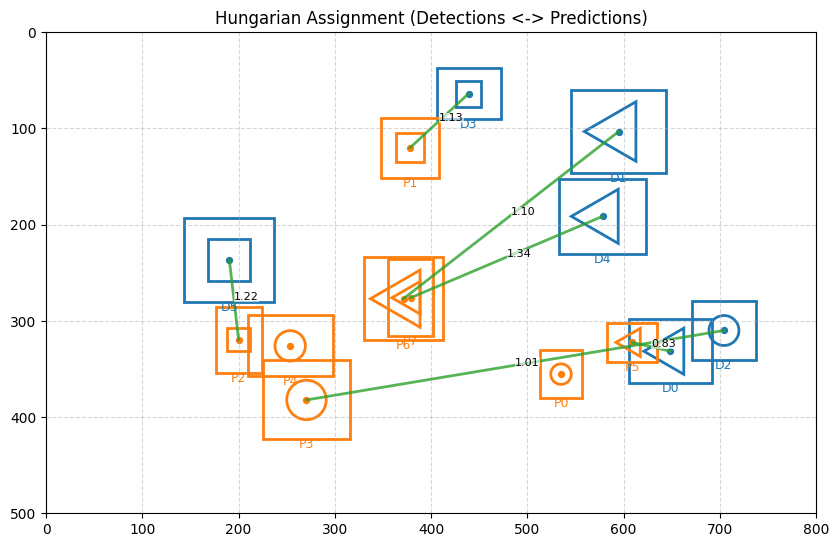

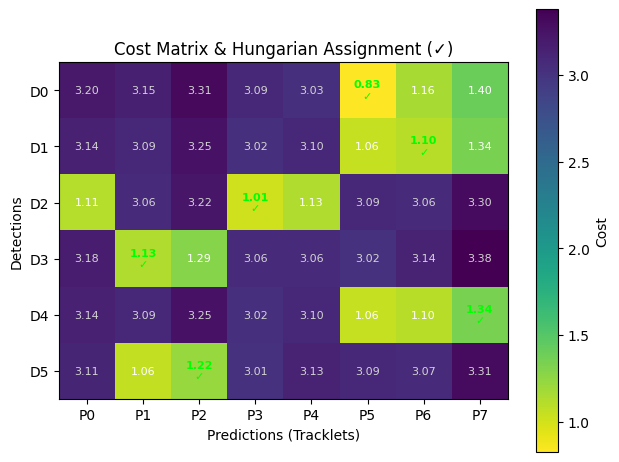

In [8]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, RegularPolygon
from scipy.optimize import linear_sum_assignment # Cần thư viện SciPy

# =============================================================================
# HÀM BỊ THIẾU (cxcywh_to_xyxy)
# =============================================================================
def cxcywh_to_xyxy(b):
    """
    Chuyển đổi từ (tâm x, tâm y, rộng, cao) sang (x_min, y_min, x_max, y_max)
    """
    w_half = b["w"] / 2
    h_half = b["h"] / 2
    x1 = b["xc"] - w_half
    y1 = b["yc"] - h_half
    x2 = b["xc"] + w_half
    y2 = b["yc"] + h_half
    return x1, y1, x2, y2

# =============================================================================
# CÁC HẰNG SỐ VÀ THIẾT LẬP
# =============================================================================
M = 6 # số detections
N = 8 # số predictions
CANVAS_W, CANVAS_H = 800, 500
BOX_W_RANGE = (40, 100)
BOX_H_RANGE = (40, 100)

# Chi phí
ALPHA_IOU = 1.0
BETA_ASPECT = 0.5
SHAPE_MISMATCH_COST = 2.0 # đủ lớn để "đè" các thành phần khác

SEED = 42 # Để kết quả có thể tái lập
rng = np.random.default_rng(SEED)
SHAPES = ["triangle", "circle", "square"]

# ================== UTILS (Từ bài) ==================
def rand_box():
    w = rng.uniform(*BOX_W_RANGE)
    h = rng.uniform(*BOX_H_RANGE)
    x = rng.uniform(w/2 + 10, CANVAS_W - w/2 - 10) # tránh tràn khung
    y = rng.uniform(h/2 + 10, CANVAS_H - h/2 - 10)
    shape = rng.choice(SHAPES)
    return dict(xc=x, yc=y, w=w, h=h, shape=shape)

def iou_box(b1, b2):
    x1a, y1a, x2a, y2a = cxcywh_to_xyxy(b1)
    x1b, y1b, x2b, y2b = cxcywh_to_xyxy(b2)
    xi1 = max(x1a, x1b); yi1 = max(y1a, y1b)
    xi2 = min(x2a, x2b); yi2 = min(y2a, y2b)
    inter = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    area_a = max(0, x2a - x1a) * max(0, y2a - y1a)
    area_b = max(0, x2b - x1b) * max(0, y2b - y1b)
    union = area_a + area_b - inter + 1e-9
    return inter / union

def aspect_ratio_diff(b1, b2):
    r1 = b1["w"] / b1["h"]
    r2 = b2["w"] / b2["h"]
    # đối xứng, ổn với scale: |log(r1/r2)|
    return abs(math.log((r1 + 1e-9)/(r2 + 1e-9)))

def shape_penalty(s1, s2):
    return 0.0 if s1 == s2 else SHAPE_MISMATCH_COST

# =============================================================================
# HÀM XÂY DỰNG MA TRẬN CHI PHÍ VÀ THUẬT TOÁN
# =============================================================================
def build_cost_matrix(dets, preds):
    C = np.zeros((len(dets), len(preds)), dtype=float)
    for i, d in enumerate(dets):
        for j, p in enumerate(preds):
            iou = iou_box(d, p)
            ar = aspect_ratio_diff(d, p)
            shp = shape_penalty(d["shape"], p["shape"])

            # --- CÔNG THỨC COST CHÍNH ---
            cost = ALPHA_IOU*(1 - iou) + BETA_ASPECT*ar + shp
            # ---------------------------

            C[i, j] = cost
    return C

def hungarian(cost):
    try:
        # Sử dụng thư viện SciPy (luôn có trên Colab)
        r, c = linear_sum_assignment(cost)
        return r, c
    except ImportError:
        print("Scipy không có, đang dùng fallback greedy (hiệu suất kém hơn)")
        # Fallback greedy: chọn min theo thứ tự tăng dần
        pairs = []
        used_r, used_c = set(), set()
        flat = [(cost[i, j], i, j) for i in range(cost.shape[0]) for j in
                range(cost.shape[1])]
        for _, i, j in sorted(flat, key=lambda x: x[0]):
            if i not in used_r and j not in used_c:
                pairs.append((i, j))
                used_r.add(i); used_c.add(j)
            if len(used_r) == min(cost.shape[0], cost.shape[1]):
                break
        r = np.array([p[0] for p in pairs], dtype=int)
        c = np.array([p[1] for p in pairs], dtype=int)
        return r, c

# =============================================================================
# HÀM TRỰC QUAN HÓA (Từ bài)
# =============================================================================
def draw_object(ax, b, color, lw=2.0):
    # vẽ bbox
    x1, y1, x2, y2 = cxcywh_to_xyxy(b)
    ax.add_patch(Rectangle((x1, y1), b["w"], b["h"], fill=False, linewidth=lw,
                           edgecolor=color))

    # vẽ hình học bên trong
    if b["shape"] == "circle":
        ax.add_patch(Circle((b["xc"], b["yc"]), radius=min(b["w"], b["h"])/4,
                            fill=False, linewidth=lw, edgecolor=color))
    elif b["shape"] == "square":
        s = min(b["w"], b["h"])/2
        ax.add_patch(Rectangle((b["xc"]-s/2, b["yc"]-s/2), s, s, fill=False,
                               linewidth=lw, edgecolor=color))
    else: # triangle
        s = min(b["w"], b["h"])/2
        tri = RegularPolygon((b["xc"], b["yc"]), numVertices=3, radius=s/1.2,
                             orientation=np.deg2rad(90), fill=False,
                             edgecolor=color, linewidth=lw)
        ax.add_patch(tri)

    # tâm
    ax.scatter([b["xc"]],[b["yc"]], color=color, s=18)

# =============================================================================
# === KHỐI THỰC THI CHÍNH ===
# =============================================================================

# 1. Tạo dữ liệu giả lập
detections = [rand_box() for _ in range(M)]
predictions = [rand_box() for _ in range(N)]

# 2. Xây dựng ma trận chi phí
C = build_cost_matrix(detections, predictions)

# 3. Chạy thuật toán Hungarian
rows, cols = hungarian(C)

# 4. In kết quả ra console
print(f"Cost matrix shape: {C.shape}")
print("Assignments (Detection Index -> Prediction Index):")
total_cost = 0
for r, c in zip(rows, cols):
    cost = C[r,c]
    total_cost += cost
    print(f"  D{r} -> P{c} (Cost: {cost:.4f})")
print(f"Total assignment cost: {total_cost:.4f}")

# =============================================================================
# === TRỰC QUAN HÓA ===
# =============================================================================

# --- 1. Trực quan hóa BBox và các cặp ghép ---
fig, ax = plt.subplots(figsize=(CANVAS_W/80, CANVAS_H/80)) # Chia 80 để ra inch
ax.set_title("Hungarian Assignment (Detections <-> Predictions)")

# Vẽ detections (xanh) & predictions (cam)
for i, d in enumerate(detections):
    draw_object(ax, d, color="tab:blue")
    ax.text(d["xc"], d["yc"]+d["h"]/2+12, f"D{i}", color="tab:blue", ha="center",
            va="bottom", fontsize=9)

for j, p in enumerate(predictions):
    draw_object(ax, p, color="tab:orange")
    ax.text(p["xc"], p["yc"]+p["h"]/2+12, f"P{j}", color="tab:orange", ha="center",
            va="bottom", fontsize=9)

# Vẽ đường nối theo assignment (xanh lá)
for i, j in zip(rows, cols):
    d = detections[i]; p = predictions[j]
    ax.plot([d["xc"], p["xc"]], [d["yc"], p["yc"]], linestyle="-", linewidth=2.0,
            color="tab:green", alpha=0.8)
    # ghi chi phí cạnh
    ax.text((d["xc"]+p["xc"])/2, (d["yc"]+p["yc"])/2, f"{C[i,j]:.2f}",
            color="k", fontsize=8,
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=0.1))

ax.set_xlim(0, CANVAS_W); ax.set_ylim(0, CANVAS_H)
ax.invert_yaxis() # Thường trục y của ảnh đi từ trên xuống
ax.set_aspect('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# --- 2. Trực quan hóa Ma trận Chi phí (Heatmap) ---
# Đây là phần trực quan hóa mục tiêu "Đánh dấu trực quan cặp được chọn (✓ trên heatmap)"
fig_hm, ax_hm = plt.subplots(figsize=(N*0.8, M*0.8))
im = ax_hm.imshow(C, cmap='viridis_r') # _r để giá trị thấp (cost thấp) có màu đẹp (tối)

# Thêm thanh màu (colorbar)
plt.colorbar(im, ax=ax_hm, label="Cost")

# Hiển thị giá trị chi phí trên từng ô
for i in range(M):
    for j in range(N):
        # Kiểm tra xem cặp (i, j) có được chọn không
        is_assigned = (i in rows) and (j == cols[np.where(rows == i)[0][0]])

        cost_val = C[i, j]
        text_content = f"{cost_val:.2f}"
        color = "w" # Mặc định màu trắng
        fontweight = "normal"

        if is_assigned:
            text_content += "\n✓" # Thêm dấu tick
            color = "lime" # Màu xanh lá nổi bật
            fontweight = "bold"
        elif cost_val > 1.9: # Ví dụ: SHAPE_MISMATCH_COST
             color = "lightgrey" # Làm mờ các ô cost quá cao

        ax_hm.text(j, i, text_content, ha="center", va="center", color=color,
                 fontsize=8, fontweight=fontweight)

ax_hm.set_xticks(np.arange(N))
ax_hm.set_yticks(np.arange(M))
ax_hm.set_xticklabels([f"P{j}" for j in range(N)])
ax_hm.set_yticklabels([f"D{i}" for i in range(M)])
ax_hm.set_xlabel("Predictions (Tracklets)")
ax_hm.set_ylabel("Detections")
ax_hm.set_title("Cost Matrix & Hungarian Assignment (✓)")

plt.tight_layout()
plt.show()

## 2.3.RE-ID / APPEARANCE MODELING

--- 1. Tạo dữ liệu mô phỏng ---
Detections (F1): 3, Predictions (F2): 4

--- 2. Tính toán các ma trận chi phí ---


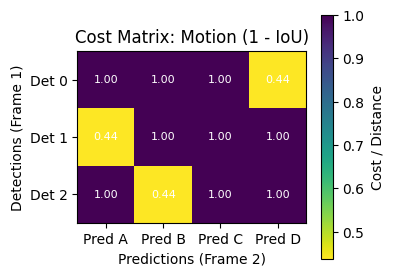

Trích xuất đặc trưng Histogram...


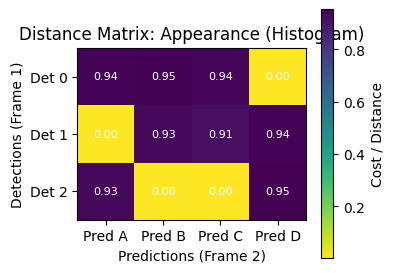


Trích xuất đặc trưng CNN (ResNet18)...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Sử dụng thiết bị: cpu


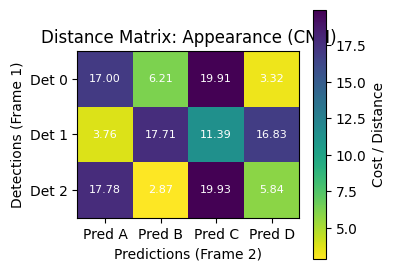


--- 3. Thử nghiệm kết hợp và gán ghép ---
Sử dụng: CNN + IoU (w_iou=0.5, w_app=0.5)

Kết quả gán ghép (Detection -> Prediction):
  Det 0 -> Pred D (Cost: 1.8804)
  Det 1 -> Pred A (Cost: 2.1001)
  Det 2 -> Pred B (Cost: 1.6527)
Tổng chi phí: 5.6332


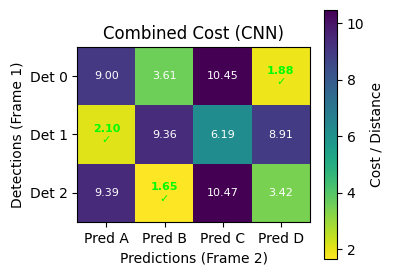

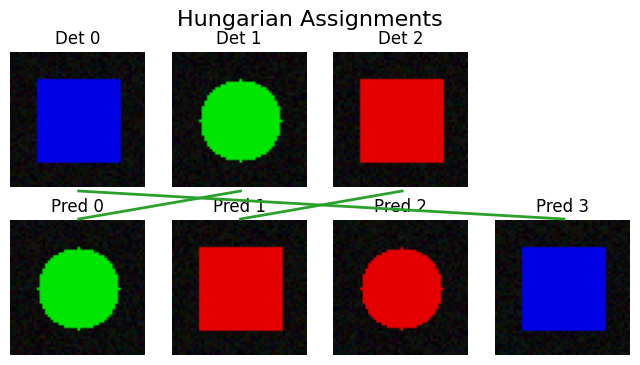

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image

# =============================================================================
# 1. HÀM TẠO DỮ LIỆU MÔ PHỎNG
# =============================================================================

def create_synthetic_patch(size=(50, 50), color_bgr=(0, 0, 255),
                           shape='rect', noise_level=0.1):
    """Tạo một patch ảnh BGR 3 kênh"""
    patch = np.zeros((size[1], size[0], 3), dtype=np.uint8)

    # Vẽ màu nền với nhiễu
    base_color_noise = (np.random.rand(size[1], size[0], 3) * 255 * noise_level).astype(np.uint8)
    patch = cv2.add(patch, base_color_noise)

    # Vẽ hình
    c = tuple(int(c * (1.0 - noise_level)) for c in color_bgr)
    cx, cy = size[0] // 2, size[1] // 2

    if shape == 'rect':
        cv2.rectangle(patch, (cx-15, cy-15), (cx+15, cy+15), c, -1)
    elif shape == 'circle':
        cv2.circle(patch, (cx, cy), 15, c, -1)

    return patch

def get_synthetic_data():
    """Tạo dữ liệu cho 2 frame (Detections và Predictions)"""
    # Detections (Frame 1)
    # (bbox [x1, y1, x2, y2], patch)
    det_patches = [
        create_synthetic_patch(color_bgr=(255, 0, 0), shape='rect'),  # 0: Xanh dương
        create_synthetic_patch(color_bgr=(0, 255, 0), shape='circle'), # 1: Xanh lá
        create_synthetic_patch(color_bgr=(0, 0, 255), shape='rect'),   # 2: Đỏ
    ]
    det_bboxes = np.array([
        [10, 10, 60, 60],  # Box 0
        [100, 50, 150, 100], # Box 1
        [50, 150, 100, 200], # Box 2
    ], dtype=float)

    # Predictions (Frame 2)
    # Đối tượng di chuyển, và có thêm 1 "distractor"
    pred_patches = [
        create_synthetic_patch(color_bgr=(0, 255, 0), shape='circle'),  # A: Xanh lá (giống 1)
        create_synthetic_patch(color_bgr=(0, 0, 255), shape='rect'),    # B: Đỏ (giống 2)
        create_synthetic_patch(color_bgr=(0, 0, 255), shape='circle'),  # C: Đỏ (DISTRACTOR)
        create_synthetic_patch(color_bgr=(255, 0, 0), shape='rect'),   # D: Xanh dương (giống 0)
    ]
    pred_bboxes = np.array([
        [110, 55, 160, 105], # Box A (từ 1)
        [60, 155, 110, 205], # Box B (từ 2)
        [200, 100, 250, 150],# Box C (Mới, nhiễu)
        [20, 15, 70, 65],    # Box D (từ 0)
    ], dtype=float)

    return det_bboxes, det_patches, pred_bboxes, pred_patches

# =============================================================================
# 2. HÀM TRÍCH XUẤT ĐẶC TRƯNG
# =============================================================================

# --- 2a. Color Histogram ---
def get_color_histogram(patch_bgr):
    """Tính histogram màu (H-S) 2D từ patch BGR"""
    patch_hsv = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([patch_hsv],
                        [0, 1],       # Dùng kênh H và S
                        None,         # Không mask
                        [16, 16],     # 16 bin cho H, 16 bin cho S
                        [0, 180, 0, 256]) # Khoảng giá trị của H, S
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    return hist.flatten()

# --- 2b. CNN Embedding (ResNet18) ---
def get_cnn_model_and_transform():
    """Tải model ResNet18 pre-trained và bộ transform"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Tải model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Identity() # Bỏ lớp classification cuối cùng
    model.to(device)
    model.eval()

    # Tải transform
    transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return model, transform, device

def get_cnn_embedding(patch_bgr, model, transform, device):
    """Trích xuất embedding 512-chiều từ patch BGR"""
    # Chuyển BGR (OpenCV) -> RGB (PIL)
    patch_rgb = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(patch_rgb)

    # Áp dụng transform
    img_t = transform(img_pil).unsqueeze(0).to(device)

    # Trích xuất
    with torch.no_grad():
        embedding = model(img_t)

    return embedding.cpu().numpy().flatten()

# =============================================================================
# 3. HÀM TÍNH CHI PHÍ VÀ GÁN GHÉP
# =============================================================================

def iou_bbox(box1, box2):
    """Tính IoU giữa 2 Bbox [x1, y1, x2, y2]"""
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-6)

def build_iou_cost_matrix(boxes1, boxes2):
    """Xây dựng ma trận chi phí IoU (cost = 1 - IoU)"""
    num1, num2 = len(boxes1), len(boxes2)
    C_iou = np.ones((num1, num2), dtype=float)
    for i in range(num1):
        for j in range(num2):
            C_iou[i, j] = 1.0 - iou_bbox(boxes1[i], boxes2[j])
    return C_iou

def build_appearance_dist_matrix(features1, features2, metric='cosine'):
    """Xây dựng ma trận khoảng cách appearance (D_app)"""
    # metric='cosine' hợp với histogram và L2-normalized embeddings
    # metric='euclidean' hợp với non-normalized embeddings
    D_app = cdist(features1, features2, metric=metric)
    return D_app

def run_assignment(cost_matrix):
    """Chạy thuật toán Hungarian"""
    rows, cols = linear_sum_assignment(cost_matrix)
    return rows, cols

# =============================================================================
# 4. HÀM TRỰC QUAN HÓA
# =============================================================================

def plot_heatmap(matrix, title, det_labels, pred_labels, assignments=None):
    """Vẽ heatmap cho ma trận chi phí/khoảng cách"""
    fig, ax = plt.subplots(figsize=(max(4, matrix.shape[1]*0.8),
                                     max(3, matrix.shape[0]*0.8)))
    im = ax.imshow(matrix, cmap='viridis_r') # _r: giá trị thấp (tốt) có màu tối
    plt.colorbar(im, ax=ax, label="Cost / Distance")

    ax.set_xticks(np.arange(len(pred_labels)))
    ax.set_yticks(np.arange(len(det_labels)))
    ax.set_xticklabels(pred_labels)
    ax.set_yticklabels(det_labels)
    ax.set_xlabel("Predictions (Frame 2)")
    ax.set_ylabel("Detections (Frame 1)")
    ax.set_title(title)

    # Hiển thị giá trị
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            is_assigned = False
            if assignments is not None:
                if i in assignments[0] and j == assignments[1][np.where(assignments[0] == i)[0][0]]:
                    is_assigned = True

            text_content = f"{matrix[i, j]:.2f}"
            color = "w"
            fontweight = "normal"
            if is_assigned:
                text_content += "\n✓"
                color = "lime"
                fontweight = "bold"

            ax.text(j, i, text_content, ha="center", va="center", color=color,
                    fontsize=8, fontweight=fontweight)
    plt.tight_layout()
    plt.show()

def plot_matches(patches1, patches2, assignments):
    """Vẽ các patch và đường nối các cặp được gán"""
    M, N = len(patches1), len(patches2)
    fig, axes = plt.subplots(2, max(M, N), figsize=(max(M, N) * 2, 4))

    # Tắt hết các trục
    for ax in axes.flat:
        ax.axis('off')

    # Vẽ Detections (Frame 1)
    for i, patch in enumerate(patches1):
        axes[0, i].imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        axes[0, i].set_title(f"Det {i}")

    # Vẽ Predictions (Frame 2)
    for j, patch in enumerate(patches2):
        axes[1, j].imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        axes[1, j].set_title(f"Pred {j}")

    # Vẽ đường nối
    for i, j in zip(assignments[0], assignments[1]):
        # Tọa độ của tâm Det i
        coord1 = axes[0, i].transData.transform_point((patches1[i].shape[1]//2, patches1[i].shape[0]))
        # Tọa độ của tâm Pred j
        coord2 = axes[1, j].transData.transform_point((patches2[j].shape[1]//2, 0))

        # Chuyển về tọa độ của Figure
        fig_coord1 = fig.transFigure.inverted().transform_point(coord1)
        fig_coord2 = fig.transFigure.inverted().transform_point(coord2)

        # Vẽ đường
        line = plt.Line2D((fig_coord1[0], fig_coord2[0]),
                            (fig_coord1[1], fig_coord2[1]),
                            transform=fig.transFigure, color='tab:green', lw=2)
        fig.add_artist(line)

    plt.suptitle("Hungarian Assignments", fontsize=16)
    plt.show()

# =============================================================================
# 5. KHỐI THỰC THI CHÍNH
# =============================================================================

# --- A. Thiết lập và tạo dữ liệu ---
print("--- 1. Tạo dữ liệu mô phỏng ---")
det_bboxes, det_patches, pred_bboxes, pred_patches = get_synthetic_data()
det_labels = [f"Det {i}" for i in range(len(det_bboxes))]
pred_labels = [f"Pred {chr(65+j)}" for j in range(len(pred_bboxes))]
print(f"Detections (F1): {len(det_bboxes)}, Predictions (F2): {len(pred_bboxes)}")

# --- B. Tính toán các ma trận ---
print("\n--- 2. Tính toán các ma trận chi phí ---")
# 2.1. Chi phí Motion (IoU)
C_iou = build_iou_cost_matrix(det_bboxes, pred_bboxes)
plot_heatmap(C_iou, "Cost Matrix: Motion (1 - IoU)", det_labels, pred_labels)

# 2.2. Chi phí Appearance (Histogram)
print("Trích xuất đặc trưng Histogram...")
det_hist_features = np.array([get_color_histogram(p) for p in det_patches])
pred_hist_features = np.array([get_color_histogram(p) for p in pred_patches])
# Dùng 'cosine' distance cho histogram đã normalize
D_hist = build_appearance_dist_matrix(det_hist_features, pred_hist_features, 'cosine')
plot_heatmap(D_hist, "Distance Matrix: Appearance (Histogram)", det_labels, pred_labels)

# 2.3. Chi phí Appearance (CNN)
D_cnn = None
try:
    print("\nTrích xuất đặc trưng CNN (ResNet18)...")
    model, transform, device = get_cnn_model_and_transform()
    print(f"Sử dụng thiết bị: {device}")

    det_cnn_features = np.array([get_cnn_embedding(p, model, transform, device) for p in det_patches])
    pred_cnn_features = np.array([get_cnn_embedding(p, model, transform, device) for p in pred_patches])

    # Dùng 'euclidean' distance (L2) cho embeddings
    D_cnn = build_appearance_dist_matrix(det_cnn_features, pred_cnn_features, 'euclidean')
    plot_heatmap(D_cnn, "Distance Matrix: Appearance (CNN)", det_labels, pred_labels)

except ImportError:
    print("Không tìm thấy PyTorch/Torchvision, bỏ qua phần CNN.")
except Exception as e:
    print(f"Lỗi khi chạy CNN (có thể do hết RAM Colab): {e}")
    print("Bỏ qua phần CNN.")


# --- C. Cell "Thử trọng số" (Cho Bài tập 3a) ---
print("\n--- 3. Thử nghiệm kết hợp và gán ghép ---")

# ======================================
# BÀI TẬP 3a: Thay đổi trọng số ở đây
W_IOU = 0.5   # Trọng số cho motion
W_APP = 0.5   # Trọng số cho appearance
# ======================================

# Chọn ma trận appearance để sử dụng
# Ưu tiên CNN nếu có, nếu không thì dùng Histogram
if D_cnn is not None:
    print(f"Sử dụng: CNN + IoU (w_iou={W_IOU}, w_app={W_APP})")
    D_app_to_use = D_cnn
    metric_name = "CNN"
else:
    print(f"Sử dụng: Histogram + IoU (w_iou={W_IOU}, w_app={W_APP})")
    D_app_to_use = D_hist
    metric_name = "Hist"

# Tính chi phí tổng hợp
C_combined = W_IOU * C_iou + W_APP * D_app_to_use

# Chạy Hungarian
assignments = run_assignment(C_combined)

# In kết quả gán ghép
print("\nKết quả gán ghép (Detection -> Prediction):")
total_cost = 0
for r, c in zip(assignments[0], assignments[1]):
    cost = C_combined[r,c]
    total_cost += cost
    print(f"  {det_labels[r]} -> {pred_labels[c]} (Cost: {cost:.4f})")
print(f"Tổng chi phí: {total_cost:.4f}")

# Trực quan hóa
plot_heatmap(C_combined, f"Combined Cost ({metric_name})",
             det_labels, pred_labels, assignments)
plot_matches(det_patches, pred_patches, assignments)

In [ ]:
!pip install ultralytics

## 3b

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-11-14 Python-3.12.12 torch-2.8.0+cu126 CPU

Fusing layers... 


--- Bắt đầu Bài tập 3b: Re-ID trên ảnh thật từ video ---
Đang tải YOLOv5s...


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Đang tải ResNet18 cho Re-ID...
Sử dụng thiết bị cho Re-ID: cpu
Đọc frame 50 và 51 từ video '/content/test2.mp4'...
Chạy YOLO trên 2 Frame...


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame 50: Tìm thấy 1 BBox.
Frame 51: Tìm thấy 1 BBox.
Tính toán ma trận chi phí...
Sử dụng: CNN Re-ID + IoU (w_iou=0.3, w_app=0.7)
Thực hiện thuật toán Hungarian...
Đang trực quan hóa kết quả...


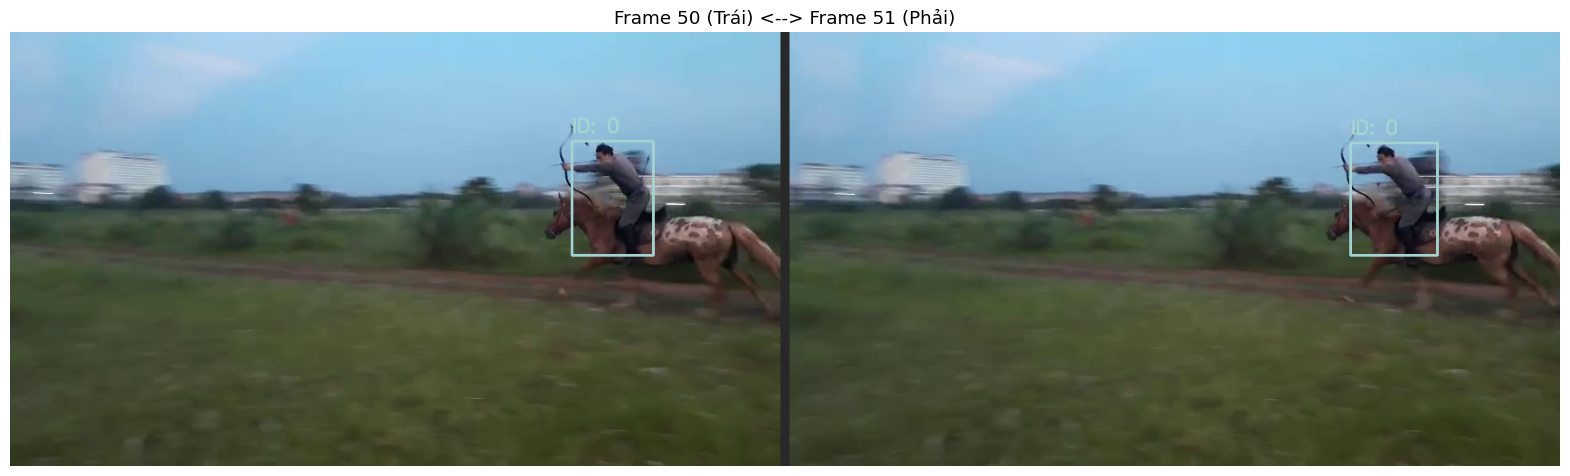

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import os
import random

# !!! THÊM DÒNG NÀY ĐỂ SỬA LỖI KHÔNG HIỂN THỊ HÌNH !!!
%matplotlib inline
# ----------------------------------------------------


# =============================================================================
# 1. CÁC HÀM TIỆN ÍCH TỪ CÁC BÀI TRƯỚC
# =============================================================================

def iou_bbox(box1, box2):
    """Tính IoU giữa 2 Bbox [x1, y1, x2, y2]"""
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-6)

def build_iou_cost_matrix(boxes1, boxes2):
    """Xây dựng ma trận chi phí IoU (cost = 1 - IoU)"""
    num1, num2 = len(boxes1), len(boxes2)
    C_iou = np.ones((num1, num2), dtype=float)
    for i in range(num1):
        for j in range(num2):
            C_iou[i, j] = 1.0 - iou_bbox(boxes1[i], boxes2[j])
    return C_iou

def get_cnn_model_and_transform():
    """Tải model ResNet18 pre-trained và bộ transform"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Identity() # Bỏ lớp classification cuối cùng
    model.to(device)
    model.eval()

    # Quan trọng: Dùng T.ToPILImage() VÌ input là mảng NumPy (OpenCV)
    transform = T.Compose([
        T.ToPILImage(), # Chuyển mảng NumPy BGR/RGB -> PIL Image
        T.Resize((224, 224)), # Resize cho ResNet
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return model, transform, device

def get_cnn_embedding(patch_bgr, model, transform, device):
    """Trích xuất embedding 512-chiều từ patch BGR"""
    if patch_bgr.size == 0:
        return np.zeros(512)

    # Chuyển BGR -> RGB vì T.ToPILImage() giả định mảng là RGB
    patch_rgb = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2RGB)

    img_t = transform(patch_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        embedding = model(img_t)

    return embedding.cpu().numpy().flatten()

def build_appearance_dist_matrix(features1, features2, metric='euclidean'):
    """Xây dựng ma trận khoảng cách appearance (D_app)"""
    if len(features1) == 0 or len(features2) == 0:
        return np.zeros((len(features1), len(features2)))
    D_app = cdist(features1, features2, metric=metric)
    return D_app

def run_assignment(cost_matrix):
    """Chạy thuật toán Hungarian"""
    if cost_matrix.shape[0] == 0 or cost_matrix.shape[1] == 0:
        return np.array([], dtype=int), np.array([], dtype=int)
    rows, cols = linear_sum_assignment(cost_matrix)
    return rows, cols

def get_random_color():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# =============================================================================
# KHỐI THỰC THI CHÍNH CHO BÀI TẬP 3B
# =============================================================================

# --- Cài đặt video và YOLO ---
# !!! THAY ĐỔI 2 DÒNG DƯỚI ĐÂY CHO PHÙ HỢP !!!
VIDEO_PATH = '/content/test2.mp4' # Đảm bảo file này đã được upload
START_FRAME = 50
# ------------------------------------

NUM_FRAMES_DIFF = 1
CONF_THRESHOLD = 0.5
CLASS_ID = 0 # 'person'

# --- Trọng số kết hợp ---
W_IOU_B3B = 0.3
W_APP_B3B = 0.7

print("--- Bắt đầu Bài tập 3b: Re-ID trên ảnh thật từ video ---")

# 1. Tải mô hình YOLOv5
print("Đang tải YOLOv5s...")
try:
    yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    yolo_model.classes = [CLASS_ID]
except Exception as e:
    print(f"Lỗi khi tải YOLOv5: {e}.")
    exit()

# 2. Tải mô hình CNN cho Re-ID
print("Đang tải ResNet18 cho Re-ID...")
try:
    cnn_model, cnn_transform, cnn_device = get_cnn_model_and_transform()
    print(f"Sử dụng thiết bị cho Re-ID: {cnn_device}")
except Exception as e:
    print(f"Lỗi khi tải ResNet18: {e}.")
    cnn_model = None

# 3. Đọc 2 frame từ video
print(f"Đọc frame {START_FRAME} và {START_FRAME + NUM_FRAMES_DIFF} từ video '{VIDEO_PATH}'...")
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print(f"Lỗi: Không thể mở video '{VIDEO_PATH}'. Kiểm tra đường dẫn.")
    exit()

cap.set(cv2.CAP_PROP_POS_FRAMES, START_FRAME)
ret1, frame1 = cap.read()
cap.set(cv2.CAP_PROP_POS_FRAMES, START_FRAME + NUM_FRAMES_DIFF)
ret2, frame2 = cap.read()
cap.release()

if not ret1 or not ret2:
    print(f"Lỗi: Không đọc được frame.")
    exit()

frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

# 4. Chạy Detector (YOLO) để lấy BBox
print("Chạy YOLO trên 2 Frame...")
results1 = yolo_model(frame1_rgb)
results2 = yolo_model(frame2_rgb)

detections1_raw = results1.xyxy[0].cpu().numpy()
detections2_raw = results2.xyxy[0].cpu().numpy()

bboxes1 = np.array([d[:4] for d in detections1_raw if d[4] >= CONF_THRESHOLD and d[5] == CLASS_ID])
bboxes2 = np.array([d[:4] for d in detections2_raw if d[4] >= CONF_THRESHOLD and d[5] == CLASS_ID])

print(f"Frame {START_FRAME}: Tìm thấy {len(bboxes1)} BBox.")
print(f"Frame {START_FRAME + NUM_FRAMES_DIFF}: Tìm thấy {len(bboxes2)} BBox.")

if len(bboxes1) == 0 or len(bboxes2) == 0:
    print("Không đủ BBox ở cả 2 frame để thực hiện Re-ID. Dừng lại.")
    exit()

# Lấy các patch (crop)
patches1 = []
for bbox in bboxes1:
    x1, y1, x2, y2 = map(int, bbox)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(frame1.shape[1], x2), min(frame1.shape[0], y2)
    patches1.append(frame1[y1:y2, x1:x2])

patches2 = []
for bbox in bboxes2:
    x1, y1, x2, y2 = map(int, bbox)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(frame2.shape[1], x2), min(frame2.shape[0], y2)
    patches2.append(frame2[y1:y2, x1:x2])

# 5. Tính toán ma trận chi phí
print("Tính toán ma trận chi phí...")
C_iou = build_iou_cost_matrix(bboxes1, bboxes2)

if cnn_model is not None:
    features1 = np.array([get_cnn_embedding(p, cnn_model, cnn_transform, cnn_device) for p in patches1])
    features2 = np.array([get_cnn_embedding(p, cnn_model, cnn_transform, cnn_device) for p in patches2])
    D_app = build_appearance_dist_matrix(features1, features2, 'euclidean')

    if D_app.max() > 0:
      D_app = D_app / D_app.max() # Chuẩn hóa về 0-1

    C_combined = W_IOU_B3B * C_iou + W_APP_B3B * D_app
    print(f"Sử dụng: CNN Re-ID + IoU (w_iou={W_IOU_B3B}, w_app={W_APP_B3B})")
else:
    print("Không có mô hình CNN, chỉ sử dụng IoU.")
    C_combined = C_iou

# 6. Thực hiện thuật toán Hungarian
print("Thực hiện thuật toán Hungarian...")
rows, cols = run_assignment(C_combined)

# 7. TRỰC QUAN HÓA (Phiên bản Colab-stable - Đã sửa lỗi canvas 3D)
print("Đang trực quan hóa kết quả...")

# Gán màu ngẫu nhiên cho mỗi ID (dựa trên index của frame 1)
id_colors = {i: get_random_color() for i in range(len(bboxes1))}

# Tạo bản sao frame để vẽ
output_frame1 = frame1.copy()
output_frame2 = frame2.copy()

# Vẽ BBox và ID lên Frame 1
for r_idx, bbox in enumerate(bboxes1):
    x1, y1, x2, y2 = map(int, bbox)
    current_id = r_idx # ID = index của detection
    color = id_colors[current_id]
    cv2.rectangle(output_frame1, (x1, y1), (x2, y2), color, 2)
    cv2.putText(output_frame1, f"ID: {current_id}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

# Vẽ BBox và ID lên Frame 2
assigned_preds_idx = set()
for r_idx, c_idx in zip(rows, cols):
    bbox = bboxes2[c_idx]
    x1, y1, x2, y2 = map(int, bbox)
    current_id = r_idx # Lấy ID từ detection frame 1
    color = id_colors[current_id]

    cv2.rectangle(output_frame2, (x1, y1), (x2, y2), color, 2)
    cv2.putText(output_frame2, f"ID: {current_id}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    assigned_preds_idx.add(c_idx)

# Vẽ các BBox mới (unassigned) ở Frame 2
for c_idx, bbox in enumerate(bboxes2):
    if c_idx not in assigned_preds_idx:
        x1, y1, x2, y2 = map(int, bbox)
        cv2.rectangle(output_frame2, (x1, y1), (x2, y2), (255, 0, 255), 2) # Màu hồng
        cv2.putText(output_frame2, f"New Track", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

# --- PHẦN HIỂN THỊ HÌNH ẢNH (ĐÃ SỬA LỖI CANVAS 3D) ---

# Gộp 2 ảnh lại thành 1 ảnh lớn để hiển thị
h1, w1, _ = output_frame1.shape
h2, w2, _ = output_frame2.shape
max_h = max(h1, h2)

# Tạo canvas 3 KÊNH (3D)
vis = np.zeros((max_h, w1 + w2 + 10, 3), dtype=np.uint8) # <-- SỬA LỖI Ở ĐÂY
vis[:, :] = 40 # Màu xám đậm cho nền

# Đặt 2 ảnh vào canvas
vis[0:h1, 0:w1] = output_frame1
vis[0:h2, w1+10 : w1+10+w2] = output_frame2

# Chuyển đổi BGR -> RGB để Matplotlib hiển thị
vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

# Hiển thị bằng Matplotlib
plt.figure(figsize=(20, 10))
plt.imshow(vis_rgb)
plt.title(f"Frame {START_FRAME} (Trái) <--> Frame {START_FRAME + NUM_FRAMES_DIFF} (Phải)")
plt.axis('off')
plt.show()

## 3. SINGLE OBJECT TRACKING SOT

Bài tập 5:

--- HIỂN THỊ FRAME 0 ĐỂ CHỌN BBOX ---
=> Click chuột phải vào ảnh dưới, chọn 'Open image in new tab'
=> Trong tab mới, di chuột vào vật thể để ước tính (x, y, w, h)


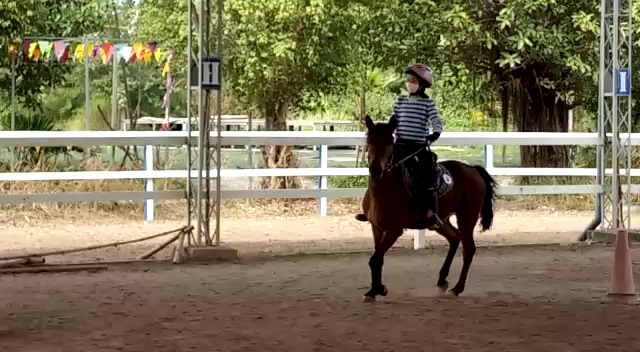

Hãy cập nhật INIT_BBOX = (x, y, w, h) dựa trên ảnh trên.
BBox hiện tại đang là: (150, 60, 60, 150)

--- BẮT ĐẦU THỬ NGHIỆM: Bài 5b: TẮT UPDATE (Model Drift) ---
[MiniSOT] Khởi tạo: Alpha=0.0, MinScore=0.0, T_Occ=0.35, UseHOG=False
--- Hiển thị Frame 0 (Khởi tạo) ---


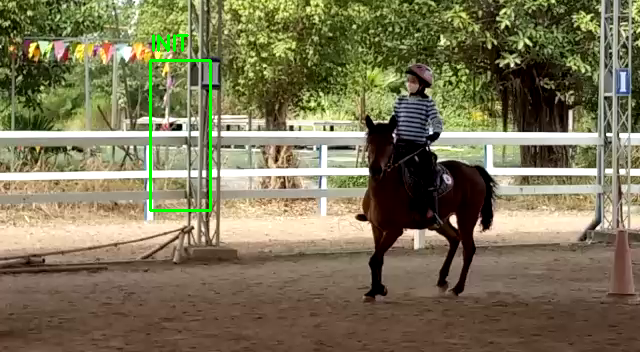

[Frame 1] Mất dấu HOÀN TOÀN.
[Frame 2] Mất dấu HOÀN TOÀN.
[Frame 3] Mất dấu HOÀN TOÀN.
[Frame 4] Mất dấu HOÀN TOÀN.
[Frame 5] Mất dấu HOÀN TOÀN.
[Frame 6] Mất dấu HOÀN TOÀN.
[Frame 7] Mất dấu HOÀN TOÀN.
--- Hiển thị Frame 50 ---


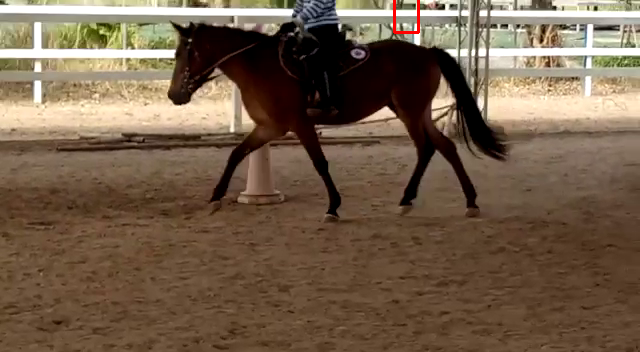

[Frame 8] Mất dấu HOÀN TOÀN.
[Frame 1] Mất dấu HOÀN TOÀN.
[Frame 2] Mất dấu HOÀN TOÀN.
[Frame 3] Mất dấu HOÀN TOÀN.
[Frame 1] Mất dấu HOÀN TOÀN.
[Frame 1] Mất dấu HOÀN TOÀN.
[Frame 1] Mất dấu HOÀN TOÀN.
[Frame 2] Mất dấu HOÀN TOÀN.
[Frame 1] Mất dấu HOÀN TOÀN.
[Frame 2] Mất dấu HOÀN TOÀN.
[Frame 1] Mất dấu HOÀN TOÀN.
[Frame 1] Mất dấu HOÀN TOÀN.
[Frame 1] Mất dấu (NCC/HOG fail). Tìm lại bằng Wide NCC!
--- Hiển thị Frame 100 ---


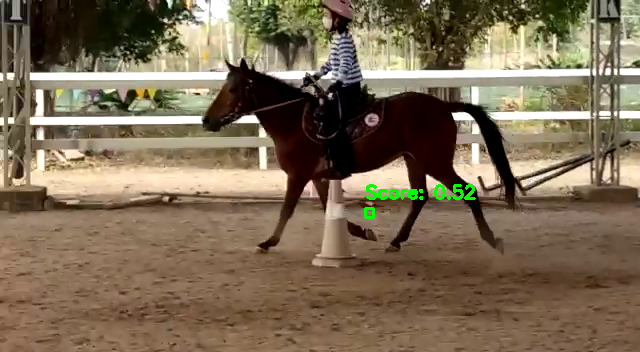

Hoàn thành! Đã xử lý 104 frames.
--- Hiển thị Frame Cuối Cùng ---


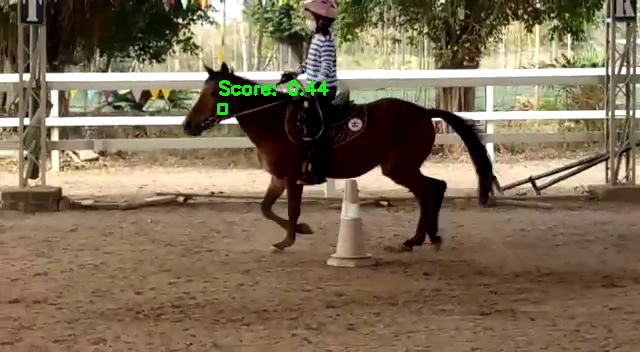


--- BẮT ĐẦU THỬ NGHIỆM: Bài 5a: CẬP NHẬT BÌNH THƯỜNG ---
[MiniSOT] Khởi tạo: Alpha=0.1, MinScore=0.45, T_Occ=0.35, UseHOG=False
--- Hiển thị Frame 0 (Khởi tạo) ---


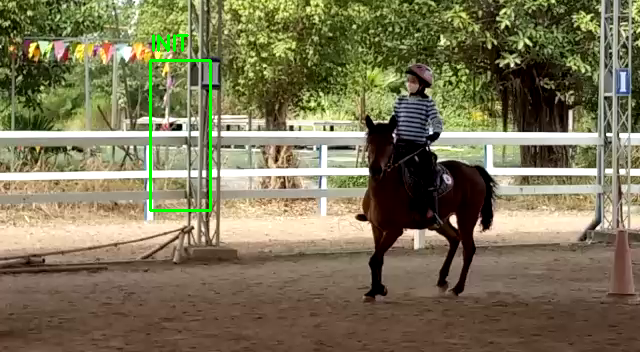

--- Hiển thị Frame 50 ---


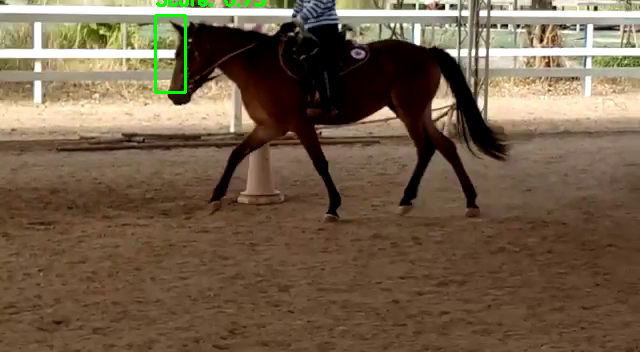

[Frame 1] Mất dấu (NCC/HOG fail). Tìm lại bằng Wide NCC!
[Frame 1] Mất dấu (NCC/HOG fail). Tìm lại bằng Wide NCC!
[Frame 1] Mất dấu (NCC/HOG fail). Tìm lại bằng Wide NCC!
[Frame 1] Mất dấu (NCC/HOG fail). Tìm lại bằng Wide NCC!
--- Hiển thị Frame 100 ---


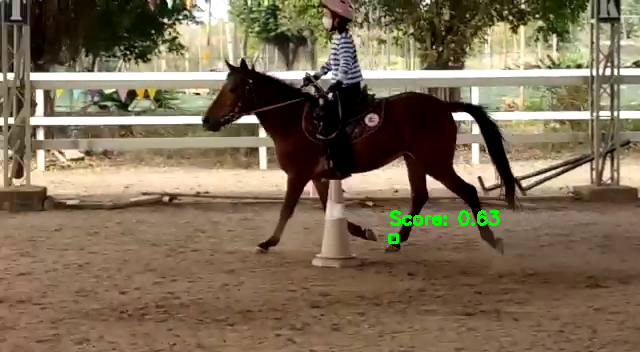

Hoàn thành! Đã xử lý 104 frames.
--- Hiển thị Frame Cuối Cùng ---


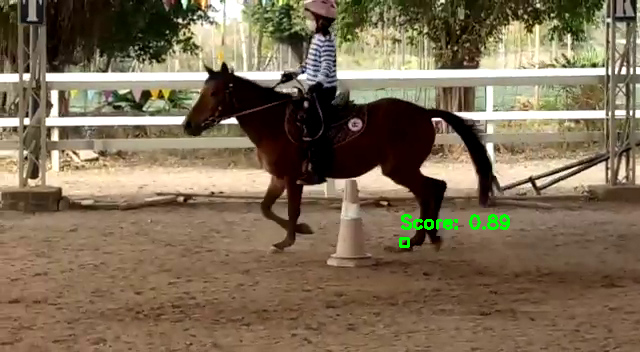

In [36]:
import cv2
import numpy as np
import os
import imutils # Cần thiết cho HOG
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Bắt buộc cho Colab để hiển thị hình ảnh
%matplotlib inline

# =============================================================================
# 1. KALMAN FILTER
# =============================================================================
class KalmanCV2D:
    def __init__(self, dt=1.0, process_var=1e-2, meas_var=0.1):
        self.dt = float(dt); dt = self.dt
        self.F = np.array([[1,0,dt,0], [0,1,0,dt], [0,0,1,0], [0,0,0,1]], dtype=float)
        self.H = np.array([[1,0,0,0], [0,1,0,0]], dtype=float)
        q = float(process_var)
        self.Q = q*np.array([[dt**4/4, 0, dt**3/2, 0], [0, dt**4/4, 0, dt**3/2],
                               [dt**3/2, 0, dt**2, 0], [0, dt**3/2, 0, dt**2]], dtype=float)
        r = float(meas_var)
        self.R = r*np.eye(2, dtype=float)
        self.x = np.zeros((4,1), dtype=float)
        self.P = np.eye(4, dtype=float)*100.0

    def init_state(self, x, y, vx=0.0, vy=0.0, P_scale=100.0):
        self.x[:] = np.array([[x],[y],[vx],[vy]], dtype=float)
        self.P = np.eye(4, dtype=float)*float(P_scale)

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x.copy()

    def update(self, z):
        z = np.asarray(z, dtype=float).reshape(2,1)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(self.P.shape[0])
        self.P = (I - K @ self.H) @ self.P
        return self.x.copy()

# =============================================================================
# 2. CÁC MODULE SOT (Từ bài giảng)
# =============================================================================
def crop(img, cx, cy, w, h):
    H, W = img.shape[:2]
    x1 = int(round(cx - w/2)); y1 = int(round(cy - h/2))
    x2 = int(round(cx + w/2)); y2 = int(round(cy + h/2))
    x1 = max(0, x1); y1 = max(0, y1); x2 = min(W, x2); y2 = min(H, y2)
    return img[y1:y2, x1:x2].copy(), (x1, y1, x2, y2)

def ncc_search(frame, template, center_pred, base_wh, scales=(0.9,1.0,1.1),
               sr_ratio=2.5):
    cx, cy = center_pred
    w0, h0 = base_wh
    SR_w, SR_h = int(w0*sr_ratio), int(h0*sr_ratio)
    sr, (sx1, sy1, sx2, sy2) = crop(frame, cx, cy, SR_w, SR_h)
    best = dict(score=-1, tl=None, scale=1.0)
    if sr.shape[0] < 10 or sr.shape[1] < 10: return None
    for s in scales:
        tw, th = max(8, int(w0*s)), max(8, int(h0*s))
        try:
            tpl = cv2.resize(template, (tw, th), interpolation=cv2.INTER_LINEAR)
        except Exception: continue
        if sr.shape[0] < th+2 or sr.shape[1] < tw+2: continue
        res = cv2.matchTemplate(sr, tpl, cv2.TM_CCOEFF_NORMED)
        _, mx, _, tl = cv2.minMaxLoc(res)
        if mx > best["score"]:
            best.update(score=mx, tl=tl, scale=s, tpl_size=(tw,th))
    if best["tl"] is None: return None
    (x, y) = best["tl"]; tw, th = best["tpl_size"]
    x1, y1 = sx1 + x, sy1 + y
    cx_new, cy_new = x1 + tw/2, y1 + th/2
    return {"score": best["score"], "center": (cx_new, cy_new),
            "wh": (tw, th), "bbox": (x1, y1, x1+tw, y1+th)}

# --- Bài tập 5: Module EMA Update ---
def ema_update_template(template, new_patch, alpha=0.05, min_score=0.45, score=None):
    if score is None or score < min_score:
        return template
    try:
        new_patch_resized = cv2.resize(new_patch, (template.shape[1], template.shape[0]))
    except Exception:
        return template
    new_template = (1-alpha)*template.astype(np.float32) + alpha*new_patch_resized.astype(np.float32)
    return new_template.astype(np.uint8)

# --- Bài tập 6: Module Occlusion & Redetect ---
def occlusion_logic(score, t_occ=0.35):
    return score < t_occ

def redetect(frame, template, base_wh):
    H, W = frame.shape[:2]
    for sr_ratio in (3.5, 4.5):
        res = ncc_search(frame, template, (W/2, H/2), base_wh,
                         scales=(0.8, 0.9, 1.0, 1.1, 1.2), sr_ratio=sr_ratio)
        if res and res["score"] > 0.5:
            return res
    return None

# =============================================================================
# 3. MODULE HOG DETECTOR
# =============================================================================
class HogReDetector:
    def __init__(self):
        self.hog = cv2.HOGDescriptor()
        self.hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
        print("[HOG] Đã khởi tạo HOG People Detector.")

    def detect(self, frame, last_center=None):
        (rects, weights) = self.hog.detectMultiScale(frame, winStride=(4, 4),
            padding=(8, 8), scale=1.05)
        if len(rects) == 0: return None
        detections = []
        for i, (x, y, w, h) in enumerate(rects):
            cx, cy = x + w/2, y + h/2
            detections.append({"center": (cx, cy), "wh": (w, h),
                               "bbox": (x, y, x+w, y+h), "score": weights[i]})
        if last_center is not None:
            best_det = min(detections, key=lambda d: np.linalg.norm(np.array(d["center"]) - np.array(last_center)))
        else:
            best_det = max(detections, key=lambda d: d["score"])
        return best_det

# =============================================================================
# 4. CLASS TRACKER TỔNG HỢP (MiniSOT) - ĐÃ SỬA LỖI
# =============================================================================
class MiniSOT:
    def __init__(self, alpha=0.05, min_score=0.45, t_occ=0.35,
                 use_hog_redetect=False):
        self.kf = KalmanCV2D()
        self.template = None
        self.base_wh = (0, 0)
        self.last_center = (0, 0)
        self.lost_counter = 0

        self.ALPHA = alpha
        self.MIN_SCORE = min_score
        self.T_OCC = t_occ
        self.USE_HOG = use_hog_redetect
        if self.USE_HOG:
            self.hog_detector = HogReDetector()

        # --- ĐÃ SỬA LỖI TYPO 'use_hog' ---
        print(f"[MiniSOT] Khởi tạo: Alpha={alpha}, MinScore={min_score}, T_Occ={t_occ}, UseHOG={use_hog_redetect}")

    def init(self, frame, bbox):
        x, y, w, h = bbox
        cx, cy = x + w/2, y + h/2
        self.base_wh = (w, h)
        self.last_center = (cx, cy)
        self.template, _ = crop(frame, cx, cy, w, h)
        if self.template.size == 0:
             print("LỖI KHỞI TẠO: INIT_BBOX nằm ngoài ảnh hoặc không hợp lệ!")
             return False
        self.kf.init_state(cx, cy)
        self.lost_counter = 0
        return True

    def track(self, frame):
        kalman_pred = self.kf.predict()
        cx_pred, cy_pred = kalman_pred[0,0], kalman_pred[1,0]
        H, W = frame.shape[:2]
        cx_pred = np.clip(cx_pred, 0, W); cy_pred = np.clip(cy_pred, 0, H)

        res = ncc_search(frame, self.template, (cx_pred, cy_pred), self.base_wh,
                         scales=(0.8, 0.9, 1.0, 1.1, 1.2))

        is_lost = False
        if res is None or occlusion_logic(res["score"], self.T_OCC):
            is_lost = True
            self.lost_counter += 1

            if self.USE_HOG:
                hog_res = self.hog_detector.detect(frame, self.last_center)
                if hog_res:
                    print(f"[Frame {self.lost_counter}] Mất dấu (NCC). Tìm lại bằng HOG!")
                    res = hog_res; is_lost = False

            if is_lost:
                ncc_res_wide = redetect(frame, self.template, self.base_wh)
                if ncc_res_wide:
                    # --- ĐÃ SỬA LỖI LOGIC TYPO ---
                    print(f"[Frame {self.lost_counter}] Mất dấu (NCC/HOG fail). Tìm lại bằng Wide NCC!")
                    res = ncc_res_wide; is_lost = False

        if not is_lost:
            self.lost_counter = 0
            new_center, new_wh, score = res["center"], res["wh"], res["score"]
            self.kf.update(new_center)
            new_patch, _ = crop(frame, new_center[0], new_center[1], new_wh[0], new_wh[1])
            if new_patch.size > 0:
                self.template = ema_update_template(self.template, new_patch,
                                                    alpha=self.ALPHA,
                                                    min_score=self.MIN_SCORE,
                                                    score=score)
            self.base_wh = new_wh
            self.last_center = new_center
            bbox_out = (new_center[0] - new_wh[0]/2, new_center[1] - new_wh[1]/2, new_wh[0], new_wh[1])
            return bbox_out, score, False

        else:
            print(f"[Frame {self.lost_counter}] Mất dấu HOÀN TOÀN.")
            w, h = self.base_wh
            bbox_out = (cx_pred - w/2, cy_pred - h/2, w, h)
            return bbox_out, 0.0, True

# =============================================================================
# 5. HÀM CHẠY INFERENCE (ĐÃ SỬA: KHÔNG LƯU VIDEO)
# =============================================================================
def run_tracking_inference(video_path, init_bbox, experiment_name,
                           alpha, min_score, t_occ, use_hog):
    print(f"\n--- BẮT ĐẦU THỬ NGHIỆM: {experiment_name} ---")

    tracker = MiniSOT(alpha=alpha, min_score=min_score, t_occ=t_occ,
                      use_hog_redetect=use_hog)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Không thể mở video {video_path}"); return

    # Đọc frame đầu tiên để khởi tạo
    ret, frame = cap.read()
    if not ret:
        print("Error: Không thể đọc frame đầu tiên."); return

    # Khởi tạo tracker
    if not tracker.init(frame, init_bbox):
        print("Khởi tạo thất bại, dừng lại."); return

    # Vẽ BBox đầu tiên
    x, y, w, h = init_bbox
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(frame, "INIT", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    print("--- Hiển thị Frame 0 (Khởi tạo) ---")
    cv2_imshow(frame)

    frame_idx = 1
    last_frame_to_show = frame.copy() # Lưu frame cuối cùng

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        bbox, score, is_lost = tracker.track(frame)
        x, y, w, h = map(int, bbox)

        color = (0, 0, 255) if is_lost else (0, 255, 0)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        text = f"Score: {score:.2f}" + (" (LOST)" if is_lost else "")
        cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        last_frame_to_show = frame.copy() # Cập nhật frame cuối

        # --- TRỰC QUAN HÓA INFERENCE ---
        # Hiển thị mỗi 50 frames để tránh làm sập Colab
        if frame_idx % 50 == 0:
            print(f"--- Hiển thị Frame {frame_idx} ---")
            cv2_imshow(frame)

        frame_idx += 1

    print(f"Hoàn thành! Đã xử lý {frame_idx} frames.")
    print("--- Hiển thị Frame Cuối Cùng ---")
    cv2_imshow(last_frame_to_show) # Hiển thị frame cuối cùng
    cap.release()
    cv2.destroyAllWindows()


# --- !!! BƯỚC 1: SỬA 2 DÒNG NÀY !!! ---
VIDEO_PATH = '/content/riding.mp4'  # Thay bằng đường dẫn video của bạn
INIT_BBOX = (150, 60, 60, 150)           # (x, y, w, h) - Thay bằng BBox của bạn
# ----------------------------------------

# --- BƯỚC 2: Chạy code này để tìm BBox (nếu bạn chưa biết) ---
print("--- HIỂN THỊ FRAME 0 ĐỂ CHỌN BBOX ---")
cap_check = cv2.VideoCapture(VIDEO_PATH)
if not cap_check.isOpened():
    print(f"Lỗi: Không thể mở video '{VIDEO_PATH}'. Vui lòng tải video lên.")
else:
    ret_check, frame_check = cap_check.read()
    if ret_check:
        print("=> Click chuột phải vào ảnh dưới, chọn 'Open image in new tab'")
        print("=> Trong tab mới, di chuột vào vật thể để ước tính (x, y, w, h)")
        cv2_imshow(frame_check)
    else:
        print("Lỗi: Không đọc được frame từ video.")
    cap_check.release()
    print(f"Hãy cập nhật INIT_BBOX = (x, y, w, h) dựa trên ảnh trên.")
    print(f"BBox hiện tại đang là: {INIT_BBOX}")


# --- BƯỚC 3: Chạy 2 thử nghiệm (SAU KHI ĐÃ CÓ INIT_BBOX ĐÚNG) ---
# Thử nghiệm 1 (Bài 5b): TẮT CẬP NHẬT (Model Drift)
run_tracking_inference(
    video_path=VIDEO_PATH,
    init_bbox=INIT_BBOX,
    experiment_name="Bài 5b: TẮT UPDATE (Model Drift)",
    alpha=0.0,       # alpha = 0, không update
    min_score=0.0,   # min_score = 0
    t_occ=0.35,
    use_hog=False
)

# Thử nghiệm 2 (Bài 5a): Cập nhật bình thường
run_tracking_inference(
    video_path=VIDEO_PATH,
    init_bbox=INIT_BBOX,
    experiment_name="Bài 5a: CẬP NHẬT BÌNH THƯỜNG",
    alpha=0.1,       # alpha = 0.1 (cập nhật chậm)
    min_score=0.45,  # min_score = 0.45 (chỉ update khi tin tưởng)
    t_occ=0.35,
    use_hog=False
)

bài tập 6

--- BẮT ĐẦU THỬ NGHIỆM: BÀI 6 (HOG RE-DETECT) ---
Cảnh báo (Bài 6b): HOG re-detector được cài đặt là 'HOG People Detector'.
Nó sẽ chỉ hoạt động nếu đối tượng trong INIT_BBOX của bạn là một NGƯỜI.

--- BẮT ĐẦU THỬ NGHIỆM: Bài 6: BẬT HOG RE-DETECT ---
[HOG] Đã khởi tạo HOG People Detector.
[MiniSOT] Khởi tạo: Alpha=0.1, MinScore=0.45, T_Occ=0.3, UseHOG=True
--- Hiển thị Frame 0 (Khởi tạo) ---


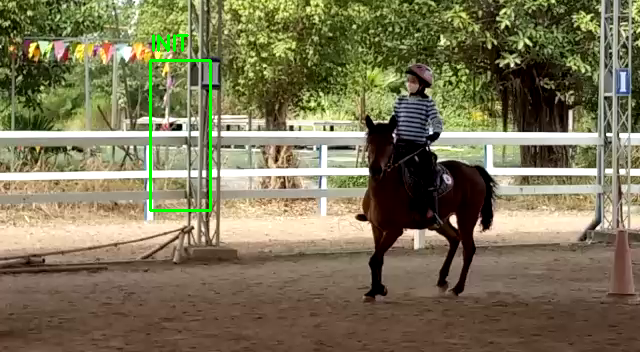

--- Hiển thị Frame 50 ---


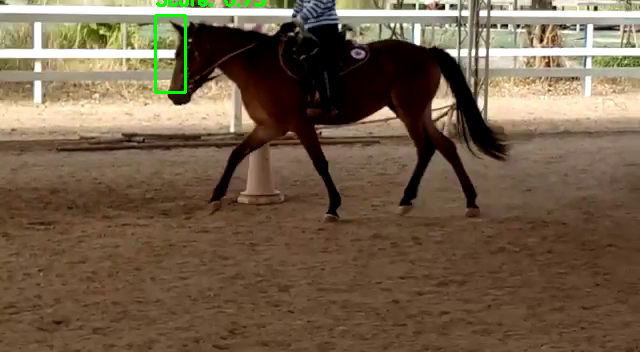

[Frame 1] Mất dấu (NCC). Tìm lại bằng HOG!
--- Hiển thị Frame 100 ---


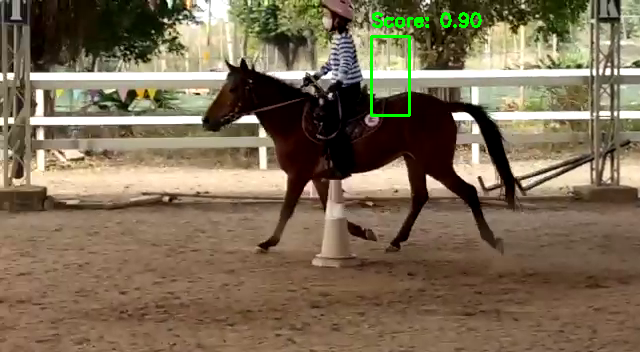

Hoàn thành! Đã xử lý 104 frames.
--- Hiển thị Frame Cuối Cùng ---


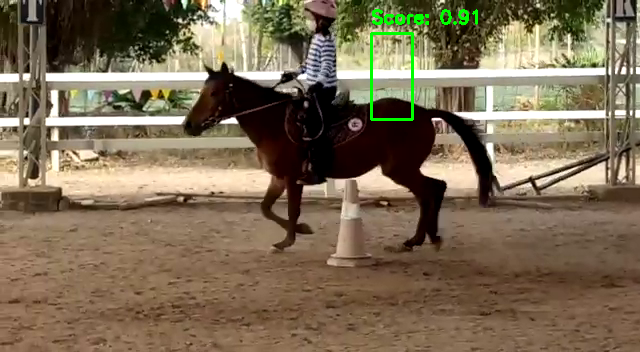


--- HOÀN THÀNH BÀI 6 ---
So sánh kết quả này với 'Bài 5a: CẬP NHẬT BÌNH THƯỜNG' để thấy sự khác biệt khi mất dấu.


In [37]:
import os
import numpy as np

print("--- BẮT ĐẦU THỬ NGHIỆM: BÀI 6 (HOG RE-DETECT) ---")

if 'VIDEO_PATH' not in globals() or 'INIT_BBOX' not in globals():
    print("Lỗi: Vui lòng chạy Cell 1 trước để định nghĩa VIDEO_PATH và INIT_BBOX.")
else:
    if not os.path.exists(VIDEO_PATH):
        print(f"Lỗi: Không tìm thấy video tại '{VIDEO_PATH}'. Vui lòng kiểm tra lại Cell 1.")
    else:
        print("Cảnh báo (Bài 6b): HOG re-detector được cài đặt là 'HOG People Detector'.")
        print("Nó sẽ chỉ hoạt động nếu đối tượng trong INIT_BBOX của bạn là một NGƯỜI.")

        run_tracking_inference(
            video_path=VIDEO_PATH,
            init_bbox=INIT_BBOX,
            experiment_name="Bài 6: BẬT HOG RE-DETECT",
            alpha=0.1,
            min_score=0.45,
            t_occ=0.3,
            use_hog=True     # BẬT HOG
        )

        print("\n--- HOÀN THÀNH BÀI 6 ---")
        print("So sánh kết quả này với 'Bài 5a: CẬP NHẬT BÌNH THƯỜNG' để thấy sự khác biệt khi mất dấu.")